In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import string
import random
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from PIL import Image
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_rows', 500)

### Content-based recommendation system

In [2]:
raw_books = pd.read_csv("C:\\Python\\Recommender system\\Book Recommend\\books.csv")

raw_books.head(3)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0


According to the dataset author: The dataset provides close to seven thousand books containing identifiers, title, subtitle, authors, categories, thumbnail url, description, published year, average rating, and number of ratings. The dataset is provided as comma-delimited CSV.\

isbn13: ISBN 13 Identifier\
isbn10: ISBN 10 Identifier\
title: Title of book\
subtitle: Subtitle of book\
authors: Authors of book separated by ";"\
categories: Categories separated by ";"\
thumbnail: URL of thumbnail\
description: Description of book\
published_year: Year of publication\
average_rating: Average rating in Goodreads

In [4]:
print("There are {} columns and {} rows in this dataset.".format(len(raw_books.columns), len(raw_books.index)))

There are 12 columns and 6810 rows in this dataset.


In [5]:
raw_books['categories'].nunique()

567

In [6]:
raw_books['categories'].unique()

array(['Fiction', 'Detective and mystery stories', 'American fiction',
       'Christian life', 'Authors, English', 'Africa, East',
       'Hyland, Morn (Fictitious character)', 'Adventure stories',
       'Arthurian romances', 'Fantasy fiction', nan, 'English drama',
       'Country life', 'English fiction', 'Clergy',
       'Aubrey, Jack (Fictitious character)',
       'Detective and mystery stories, English', 'Black Death',
       'Human cloning', 'Science fiction', 'Great Britain',
       'American essays', 'China', 'Capitalism', 'Ireland',
       'Juvenile Fiction', "Children's stories, English",
       'Male friendship', 'Literary Collections',
       'Beresford, Tommy (Fictitious character)',
       'Imaginary wars and battles', 'Dysfunctional families',
       'Poirot, Hercule (Fictitious character)', 'Christmas stories',
       'Marple, Jane (Fictitious character)', 'Belgians',
       'Battle, Superintendent (Fictitious character)',
       'Baggins, Frodo (Fictitious character

In [8]:
raw_books['categories'].value_counts().head(10)

Fiction                      2588
Juvenile Fiction              538
Biography & Autobiography     401
History                       264
Literary Criticism            166
Philosophy                    160
Comics & Graphic Novels       159
Religion                      137
Drama                         132
Juvenile Nonfiction           116
Name: categories, dtype: int64

#### Select genres
Select only the books with four genres (Fiction, Juvenile Fiction, Biography & Autobiography, History) most present in the dataset.

In [9]:
books = raw_books.loc[raw_books['categories'].isin(['Fiction', 'Juvenile Fiction', 'Biography & Autobiography', 'History'])]

In [10]:
books.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
12,9780006482079,0006482074,Warhost of Vastmark,NaN,Janny Wurts,Fiction,http://books.google.com/books/content?id=uOL0f...,"Tricked once more by his wily half-brother, Ly...",1995.0,4.03,522.0,2966.0
35,9780006646006,000664600X,Ocean Star Express,NaN,Mark Haddon;Peter Sutton,Juvenile Fiction,http://books.google.com/books/content?id=I2QZA...,Joe and his parents are enjoying a summer holi...,2002.0,3.50,32.0,1.0
37,9780006906018,000690601X,The Princess of the Chalet School,NaN,Elinor Mary Brent-Dyer,Juvenile Fiction,http://books.google.com/books/content?id=EJcQP...,NaN,2000.0,4.10,159.0,446.0


In [15]:
import plotly.express as px

fig = px.histogram(books, x="categories", color="categories", width=1000, height=500, text_auto=True)

fig.show()

#### View title and description of two random examples

In [16]:

print(books['title'] [120])
print(books['description'] [120])
print('\n\n')
print(books['title'] [200])
print(books['description'] [200])

Going Postal
Arch-swindler Moist Van Lipwig never believed his confidence crimes were hanging offenses -- until he found himself with a noose tightly around his neck, dropping through a trapdoor, and falling into ... a government job? By all rights, Moist should have met his maker. Instead, it's Lord Vetinari, supreme ruler of Ankh-Morpork, who promptly offers him a job as Postmaster. Since his only other option is a nonliving one, Moist accepts the position -- and the hulking golem watchdog who comes along with it, just in case Moist was considering abandoning his responsibilities prematurely. Getting the moribund Postal Service up and running again, however, may be a near-impossible task, what with literally mountains of decades-old undelivered mail clogging every nook and cranny of the broken-down post office building; and with only a few creaky old postmen and one rather unstable, pin-obsessed youth available to deliver it. Worse still, Moist could swear the mail is talking to him.

#### Drop rows with null values in description

In [17]:
books.dropna(subset=["description"], inplace=True)

C:\Users\blaze\AppData\Local\Temp\ipykernel_21720\337872338.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
books["description"].isnull().sum()

0

In [19]:
# USING REGULAR EXPRESSIONS (REGEX)
books = books[~books.description.str.contains('[0-9].*[0-9].*[printing]')]

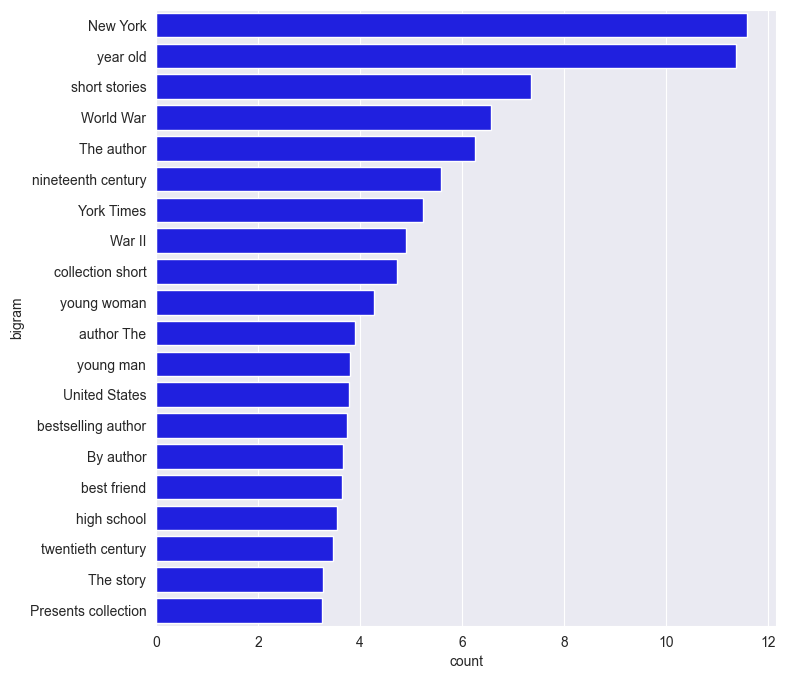

In [22]:
# CONVERT DESCRIPTION INTO VECTORS AND USE BIGRA,
tf = TfidfVectorizer(ngram_range=(2,2), stop_words="english", lowercase=False)

tfidf_matrix = tf.fit_transform(books["description"])
total_words =  tfidf_matrix.sum(axis=0)

# WORK FREQUENCY
freq = [(word, total_words[0, index]) for word, index in tf.vocabulary_.items()]
freq = sorted(freq, key=lambda x: x[1], reverse=True)

# CREATE A PANDAS DATAFRA,E
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

# TOP 20 BIGRAMS
bigram = bigram.head(20)

# PLOT BARPLOT
plt.figure(figsize=(8, 8))
sns.barplot(x=bigram['count'], y=bigram['bigram'], color='blue')
plt.show()

#### Preprocessing

In [23]:
# REMOVE NON ASCII CHARACTERS
def remove_non_ascii(string):
    return "".join(c for c in string if ord(c) < 128)

# MAKE DESCRIPTION TEXT LOWER CASE
def make_lower_case(text):
    return text.lower()

# REMOVE STOP WORDS
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [word for word in text if not word in stops]
    text=" ".join(text)
    return text

# REMOVE PUNCTUATIONS
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# REMOVE HTML CODES
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

#### Create new column called "cleaned_description" and apply all functions

In [24]:
books["cleaned_description"] = books["description"].apply(remove_non_ascii)
books["cleaned_description"] = books["description"].apply(make_lower_case)
books["cleaned_description"] = books["description"].apply(remove_stop_words)
books["cleaned_description"] = books["description"].apply(remove_punctuation)
books["cleaned_description"] = books["description"].apply(remove_html)


#### Make recommendations by title

In [85]:
def recommend(title, category):

    # MATCH THE CATEGORY WITH THE COLUMN "CATEGORIES" OF THE DATASET
    data = books.loc[books["categories"] == category]

    # RESET INDEX
    data.reset_index(level = 0, inplace = True) 

    # INDEX TO A PANDAS SERIES
    indices = pd.Series(data.index, index=data["title"])

    # CONVERT THE BOOK TITLE INTO VECTORS AND USE BIGRAM
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data["title"])
    
    # CALCULATE THE SIMILARITY MEASURE
    similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    
    # GET THE INDEX OF ORIGINAL TITLE
    index = indices[title]

    # PAIRWISE SIMILARITY SCORES
    similarity = list(enumerate(similarity[index]))
    
    # SORT THE BOOKS
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)
    
    # GET TOP 5 MOST SIMILAR BOOKS
    similarity  = similarity [1:6]
    
    # INDICES OF TOP 5
    book_indices = [i[0] for i in similarity]

    # TOP 5 RECOMMENDATION
    rec = data[['title', 'thumbnail']].iloc[book_indices]
    
    # PRINT THE BOOKS TITLE
    print(rec['title'])
    
    # PRINT THE TOP 5 BOOK COVER
    for i in rec['thumbnail']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)

[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0)]
0                             Tyranny of the Majority
1        Presidential Power and the Modern Presidents
2                                  Sex with the Queen
3                           The Chaneysville Incident
4    Legends, Lies & Cherished Myths of World History
Name: title, dtype: object


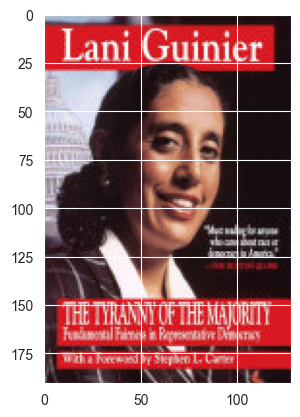

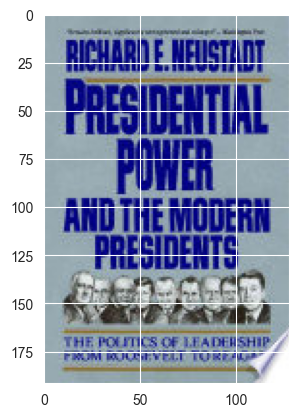

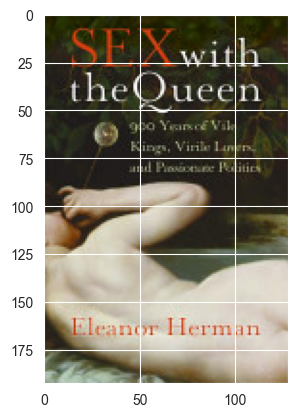

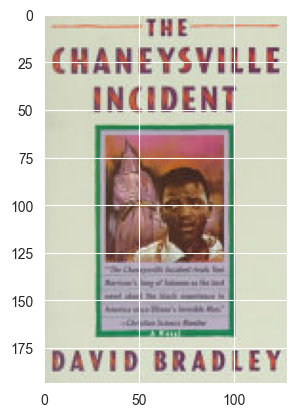

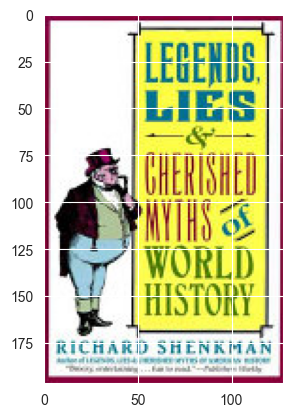

In [86]:
# TEST
recommend("A People's History of the United States", "History")

#### Make recommendations by description

In [90]:
def recommend(title, category):
    
    # MATCH THE CATEGORY WITH THE COLUMN "CATEGORIES" OF THE DATASET
    data = books.loc[books['categories'] == category] 
    # RESET INDEX
    data.reset_index(level = 0, inplace = True) 
    
    # INDEX TO A PANDAS SERIES
    indices = pd.Series(data.index, index = data['title'])
    
    # CONVERT THE BOOK TITLE INTO VECTORS AND USE BIGRAM
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_description'])
    
    # CALCULATE THE SIMILARITY MEASURE
    similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # GET THE INDEX OF ORIGINAL TITLE
    index = indices[title]
    
    # PAIRWISE SIMILARITY SCORES
    similarity = list(enumerate(similarity[index]))
    
    # SORT THE BOOKS
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)
    
    # GET TOP 5 MOST SIMILAR BOOKS
    similarity  = similarity [1:6]
    
    # INDICES OF TOP 5
    book_indices = [i[0] for i in similarity]

    # TOP 5 RECOMMENDATION
    rec = data[['title', 'thumbnail']].iloc[book_indices]
    
    # PRINT THE BOOKS TITLE
    print(rec['title'])
    
    # PRINT THE TOP 5 BOOK COVER
    for i in rec['thumbnail']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)

1872                A Murder is Announced
652                        The Ruined Map
1184                      Send No Flowers
168     The Third Man and the Fallen Idol
1871                   Evil Under the Sun
Name: title, dtype: object


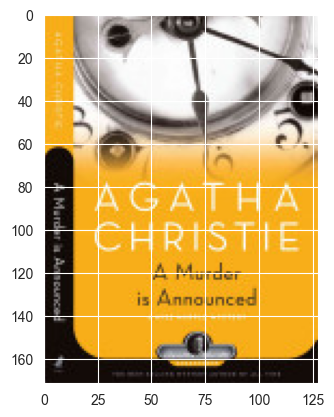

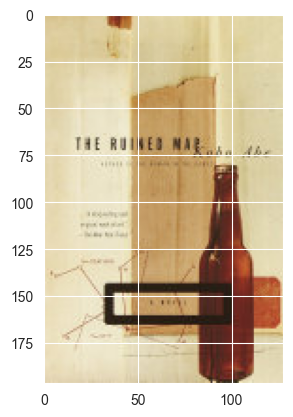

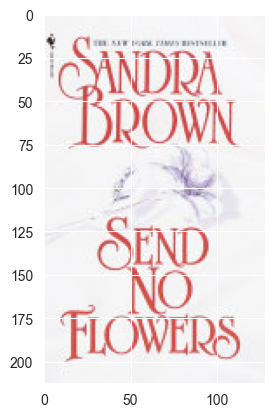

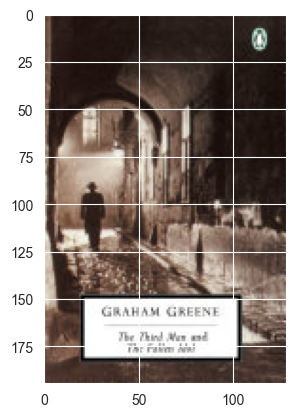

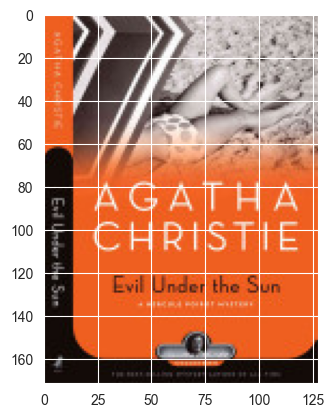

In [91]:
recommend("Taken at the Flood", "Fiction")